### PTC Fitting
This notebook is a modified version of Simon's welcome_to_PTC.ipynb, preserving the parts that access the data, but adding a more detailed evaluation of the parameters of the resulting Photon Transfer Curve.

### Imports

In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
import os
import scipy.optimize
from copy import deepcopy

# LSST stack imports
from lsst.daf.persistence import Butler
#import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

In [4]:
# Define the model for the PTC curve and a function to optimize

In [5]:
def ptc_func(pars, x):
    """
    Model for variance vs mean.
    See Astier et al.
    """
    a00, gain, intcpt = pars
    return 0.5/(a00*gain*gain)*(1 - numpy.exp(-2*a00*x*gain)) + intcpt/(gain*gain)

In [6]:
def residuals(pars, x, y):
    "Residuals function for least-squares fit of PTC curve."
    a00, gain, intcpt = pars
    return (y - ptc_func(pars, x))/numpy.sqrt(y)

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [7]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False
isr_config.doSaturationInterpolation=False

### Construct the `IsrTask` with the above configuration

In [8]:
isr = IsrTask(config=isr_config)

In [9]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})
mean = {}
var = {}
exp_time = {}

i = 1
for visit1, visit2 in zip(visits[:-1:2], visits[1::2]): # loop over pairs of images
    # Get ISR data for first image
    dId = {'visit': visit1, 'detector': 2}
    raw1 = butler.get('raw', **dId)
    bias1 = butler.get('bias', **dId)
    time1 = raw1.getInfo().getVisitInfo().getExposureTime()
    
    # Get ISR data for second image
    dId = {'visit': visit2, 'detector': 2}
    raw2 = butler.get('raw', **dId)
    bias2 = butler.get('bias', **dId)
    time2 = raw2.getInfo().getVisitInfo().getExposureTime()
    if abs(time1 - time2) > 0.01:
        "Mismatched exptimes"
        continue
    
    # run ISR on both images
    result1 = isr.run(raw1, bias=bias1)
    result2 = isr.run(raw2, bias=bias2)
    
    detector = result1.exposure.getDetector()
    amp = detector[3]

    sub_im1 = result1.exposure.getMaskedImage()[amp.getBBox()]
    sub_im2 = result2.exposure.getMaskedImage()[amp.getBBox()]
    
    diff_im = sub_im1.clone()
    
    # Scale the second image to have the same mean
    im2_scale = sub_im2.clone()
    im2_scale *= afwMath.makeStatistics(sub_im1, afwMath.MEAN).getValue()
    im2_scale /= afwMath.makeStatistics(sub_im2, afwMath.MEAN).getValue()
    diff_im -= im2_scale
    
    var[visit1] = afwMath.makeStatistics(diff_im, afwMath.VARIANCE).getValue()/2
    mean[visit1] = afwMath.makeStatistics(sub_im2, afwMath.MEAN).getValue()
    
    print("visit %i,%i -- %i of %i -- mean=%f"%(visit1, visit2, i, len(visits)/2, mean[visit1]))
    i += 1
    

visit 258339739,258339769 -- 1 of 39 -- mean=91.904087
visit 258339807,258339839 -- 2 of 39 -- mean=122.637264
visit 258339875,258339908 -- 3 of 39 -- mean=180.398270
visit 258339945,258339976 -- 4 of 39 -- mean=236.103258
visit 258340014,258340047 -- 5 of 39 -- mean=326.829207
visit 258340086,258340120 -- 6 of 39 -- mean=566.379527
visit 258340159,258340176 -- 7 of 39 -- mean=768.134973
visit 258340202,258340220 -- 8 of 39 -- mean=1036.040064
visit 258340244,258340265 -- 9 of 39 -- mean=1347.095688
visit 258340290,258340314 -- 10 of 39 -- mean=1895.751761
visit 258340341,258340363 -- 11 of 39 -- mean=2484.367278
visit 258340392,258340416 -- 12 of 39 -- mean=3331.440980
visit 258340449,258340477 -- 13 of 39 -- mean=4398.578437
visit 258340511,258340542 -- 14 of 39 -- mean=5840.022160
visit 258340581,258340618 -- 15 of 39 -- mean=7690.708476
visit 258340662,258340707 -- 16 of 39 -- mean=10460.930685
visit 258340758,258340811 -- 17 of 39 -- mean=13597.041777
visit 258340873,258340939 -- 

In [10]:
### Fit the PTC

In [11]:
visit_keys = mean.keys()
x = [mean[visit] for visit in visit_keys]
y = [var[visit] for visit in visit_keys]

In [12]:
# Make an intial guess of the fit parameters
pars = 1e-6, 0.3, 0

# Refine the guess by selecting all points with mean < 1e5
x = numpy.array(x)
y = numpy.array(y)
index = list(numpy.where(x < 1e5)[0])
results = scipy.optimize.leastsq(residuals, pars, full_output=1, args=(x[index],y[index]))

In [13]:
# Set up parameters for an iterative fit, throwing out the points more than sig_cut from the fit
pars = (results[:2][0][0], results[:2][0][1], results[:2][0][2])
index_old = []
count = 1
sig_cut = 5

In [14]:
while index != index_old and count < 10:
    results = scipy.optimize.leastsq(residuals, pars, full_output=1,
                                     args=(x[index], y[index]))
    sig_resids = (y - ptc_func(pars, x))/numpy.sqrt(y)
    index_old = deepcopy(index)
    index = list(numpy.where(numpy.abs(sig_resids) < sig_cut)[0])
    pars, cov = results[:2]
    count += 1

ptc_a00 = pars[0]
ptc_a00_error = numpy.sqrt(cov[0][0])
ptc_gain = pars[1]
ptc_error = numpy.sqrt(cov[1][1])
ptc_noise = numpy.sqrt(pars[2])
ptc_noise_error = 0.5/ptc_noise*numpy.sqrt(cov[2][2])
# Cannot assume that the mean values are sorted
ptc_turnoff = max(x[index])

In [15]:
print('Amplifier:  ' + amp['name'])
print('Brighter-fatter k: %6.2e +/- %6.2e' % (ptc_a00, ptc_a00_error))
print('Gain (e-/ADU):     %6.3f +/- %6.3f' % (ptc_gain, ptc_error))
print('Noise (e-):        %6.3f +/- %6.3f' % (ptc_noise, ptc_noise_error))
print('PTC turnoff (ADU): %6.2e' % ptc_turnoff)

Amplifier:  C13
Brighter-fatter k: 2.84e-06 +/- 4.20e-08
Gain (e-/ADU):      0.680 +/-  0.002
Noise (e-):         4.662 +/-  0.350
PTC turnoff (ADU): 1.45e+05


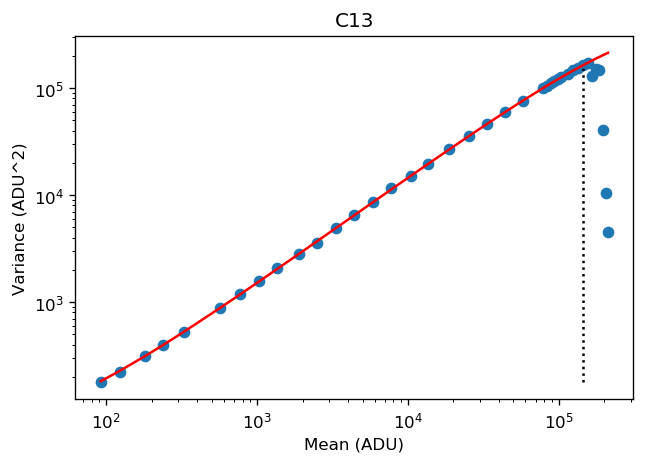

In [16]:
plt.scatter(x, y)
plt.plot(x, ptc_func(pars, x),color='red')
plt.xlabel('Mean (ADU)')
plt.ylabel('Variance (ADU^2)')
plt.xscale('log')
plt.yscale('log')
plt.title(amp['name'])
plt.plot([ptc_turnoff,ptc_turnoff],[numpy.min(y[index]), numpy.max(y[index])],'k:')

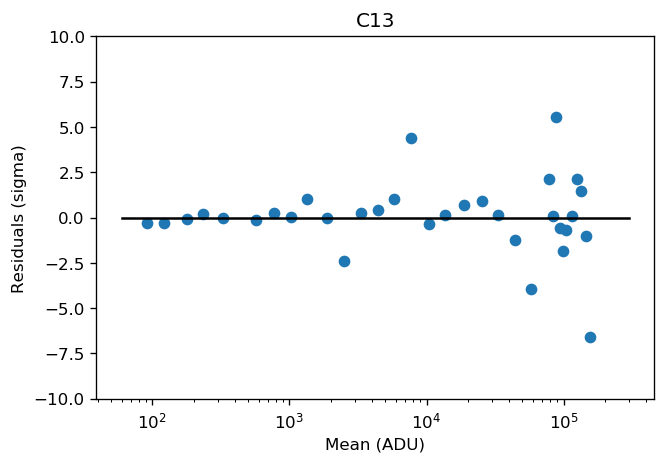

In [17]:
plt.scatter(x,residuals(pars, x, y))
plt.xlabel('Mean (ADU)')
plt.ylabel('Residuals (sigma)')
plt.xscale('log')
plt.ylim([-10,10])
plt.title(amp['name'])
plt.plot([60, 3e5],[0,0], 'k-')